# Study of a more simple trajectory
We will study a collection of 3 trajectories in order to compare the visualisation of each library

In [2]:
"""
Function to compute the execution time.
"""
from datetime import timedelta
import time
def get_time(f, kwargs={}):
    times = []
    result = None
    for i in range(1):
        print("\nmeasure",i+1)
        t = time.time()
        result = f(**kwargs)
        times.append(time.time()-t)
        
    print("\nall times:", times)
    a = min(times)
    b = max(times)
    print("times' outliers:",a,"&",b)
    t = abs((sum(times)-a-b))/1
    print("benchmark time",str(t)+"s","or", timedelta(seconds=t))
    return result

In [3]:
import numpy as np
import pandas as pd
from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import movingpandas as mpd
#from holoviews import opts, dim
import hvplot
import warnings
warnings.simplefilter("ignore")

In [3]:
SIZE = "sample"

# Ships Trajectories

In [4]:
PATH='datasets/ships_'+SIZE+'.csv'

In [5]:
df = pd.read_csv(PATH)

In [6]:
traj = get_time(mpd.TrajectoryCollection,{"data":df, "traj_id_col":'id', "t":'Timestamp', "x":'Longitude', "y":'Latitude'})


measure 1

measure 2

measure 3

measure 4

measure 5

all times: [0.28894948959350586, 0.2877638339996338, 0.19834280014038086, 0.20352482795715332, 0.2886993885040283]
times' outliers: 0.19834280014038086 & 0.28894948959350586
benchmark time 0.2599960168202718s or 0:00:00.259996


### Outlier Detection

In [7]:
traj.add_speed(True)
cleaned_traj = get_time(mpd.OutlierCleaner(traj).clean,{"columns":{'speed': 1.5}})

apply time 0.44533514976501465

measure 1

measure 2

measure 3

measure 4

measure 5

all times: [0.007030010223388672, 0.006766080856323242, 0.00667881965637207, 0.006633281707763672, 0.006838560104370117]
times' outliers: 0.006633281707763672 & 0.007030010223388672
benchmark time 0.00676115353902181s or 0:00:00.006761


In [12]:
gdf=cleaned_traj.to_point_gdf()

In [16]:
gdf["Longitude"]=gdf["geometry"].x
gdf["Latitude"]=gdf["geometry"].y
gdf.drop(columns=['geometry']).to_csv("output/mpd-cleaned.csv")

# cars trajectories

In [4]:
PATH='datasets/cars_'+SIZE+'.csv'

In [5]:
df = pd.read_csv(PATH)

In [6]:
traj = mpd.TrajectoryCollection(data=df, traj_id_col='id', t='Timestamp', x='Longitude', y='Latitude')

In [7]:
len(traj.to_point_gdf())
traj.to_point_gdf()["id"].unique()

array([8])

### Speed Computation

In [18]:
get_time(traj.add_speed,{"overwrite":True})


measure 1
apply time 0.2991039752960205
apply time 1.946190595626831

measure 2
apply time 0.26677656173706055
apply time 2.06768798828125

measure 3
apply time 0.28531599044799805
apply time 1.949270486831665

measure 4
apply time 0.2691829204559326
apply time 2.1018288135528564

measure 5
apply time 0.27077460289001465
apply time 1.9769387245178223

all times: [2.2800545692443848, 2.357170820236206, 2.2594268321990967, 2.3927884101867676, 2.270655870437622]
times' outliers: 2.2594268321990967 & 2.3927884101867676
benchmark time 2.3026270866394043s or 0:00:02.302627


### Stop detection

In [8]:
stop_points = get_time(mpd.TrajectoryStopDetector(traj).get_stop_points,{"min_duration":timedelta(minutes=30), "max_diameter":20})


measure 1
0.9456503391265869

all times: [1.4358727931976318]
times' outliers: 1.4358727931976318 & 1.4358727931976318
benchmark time 1.4358727931976318s or 0:00:01.435873


In [9]:
print("nombre de points d'arret",len(stop_points))

nombre de points d'arret 9


### Compression

In [42]:
tolerance = 1.0 # meters

In [ ]:
compressed_topDown = get_time(mpd.TopDownTimeRatioGeneralizer(traj).generalize,{"tolerance": tolerance / 111139})

In [21]:
print("nombre de points apres compression",len(compressed_topDown.to_point_gdf()))

nombre de points apres compression 4


In [39]:
compressed_DP = get_time(mpd.DouglasPeuckerGeneralizer(traj).generalize,{"tolerance": tolerance / 111139})


measure 1

measure 2

measure 3

measure 4

measure 5

all times: [11.282588005065918, 15.193400621414185, 14.870700359344482, 14.882068634033203, 15.470395803451538]
times' outliers: 11.282588005065918 & 15.470395803451538
benchmark time 14.982056538263956s or 0:00:14.982057


In [41]:
print("nombre de points apres compression",len(compressed_DP.to_point_gdf()))

nombre de points apres compression 3871


### Segmentation

In [ ]:
segmented = get_time(mpd.ObservationGapSplitter(traj).split,{"gap":timedelta(hours=0.5)})

In [ ]:
segmented.to_point_gdf()

### visualisation


measure 1

all times: [1.0357811450958252]
times' outliers: 1.0357811450958252 & 1.0357811450958252
benchmark time 0.3452603816986084s or 0:00:00.345260


<AxesSubplot:>

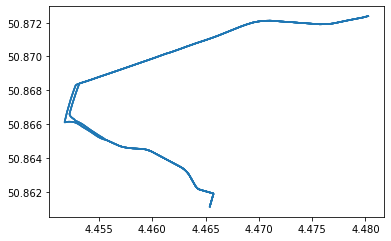

In [14]:
get_time(traj.plot)


In [ ]:
get_time(traj.hvplot,{"line_width":5.0})

In [36]:
#traj.hvplot(line_width=5)

:Overlay
   .Tiles.I :Tiles   [x,y]
   .Path.I  :Path   [Longitude,Latitude]
   .Path.II :Path   [Longitude,Latitude]

In [40]:
#compressed_DP.hvplot(line_width=5)

:Overlay
   .Tiles.I :Tiles   [x,y]
   .Path.I  :Path   [Longitude,Latitude]
   .Path.II :Path   [Longitude,Latitude]

In [ ]:
"""hvplot_defaults = {'tiles':'CartoLight', 'frame_height':700, 'frame_width':700, 'cmap':'Viridis', 'colorbar':True}
kwargs = {**hvplot_defaults,'c':'speed', 'line_width':2}
plot = (traj.hvplot(title='Original Trajectories', **kwargs)
hvplot.save(plot, 'movingpandas.html')"""

In [ ]:
"""# scikit-mobility stop points2006-05-03 12:48:59
df = pd.DataFrame([
  {'geometry':Point(18.374787,57.692492), 't':datetime(2006,5,3,12,48,59)},
  {'geometry':Point(18.130432,56.961313), 't':datetime(2018,5,3,14,40,17)}
]).set_index('t')
gdf = GeoDataFrame(df,crs="EPSG:4326")
toy_traj = mpd.Trajectory(gdf, 1)
toy_traj.hvplot(title='Original Trajectories', **kwargs)"""

In [ ]:
"""stop_point_plot = plot * stop_points.hvplot(geo=True, color="red") * gdf.hvplot(geo=True, color="blue")
#hvplot.save(stop_point_plot, 'moving_pandas_stop_detection.html')
stop_point_plot"""

# TO DELETE

In [4]:
PATH='datasets/cars_sample.csv'
df = pd.read_csv(PATH)
traj = mpd.Trajectory(df=df, traj_id=8, t='Timestamp', x='Longitude', y='Latitude')
traj

Trajectory 8 (2020-06-01 08:56:08.148000 to 2020-06-04 21:57:14.847135) | Size: 4941 | Length: 28928.4m
Bounds: (4.451760899999996, 50.86107290000001, 4.480320800000002, 50.87241019999999)
LINESTRING (4.46537349999999 50.86107290000001, 4.465385801954695 50.86110016684582, 4.4653981039093

<AxesSubplot:>

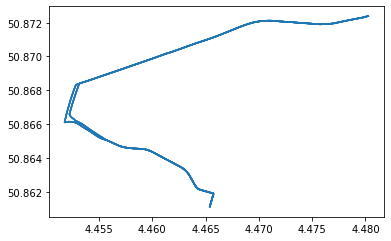

In [5]:
traj.plot()

In [10]:
compressed_DP = mpd.DouglasPeuckerGeneralizer(traj).generalize(0.00009)
compressed_DP

Trajectory 8 (2020-06-01 08:56:08.148000 to 2020-06-04 21:57:14.847135) | Size: 216 | Length: 28878.3m
Bounds: (4.451760899999996, 50.86107290000001, 4.480320800000002, 50.87241019999999)
LINESTRING (4.46537349999999 50.86107290000001, 4.465406299999998 50.86114559999999, 4.4657447000000

<AxesSubplot:>

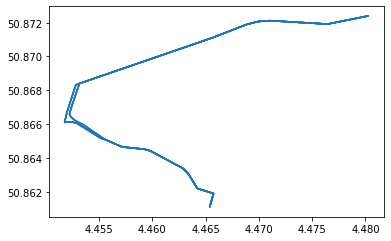

In [7]:
compressed_DP.plot()

125


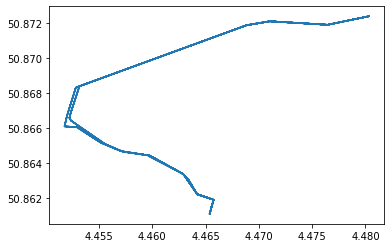

In [11]:
import matplotlib.pyplot as plt
coords = traj.to_linestring().simplify(0.00009, preserve_topology=False).coords
print(len(coords))
plt.plot([x[0] for x in coords],[y[1] for y in coords])